# How can remote sensing be used to monitor active storage sites?

In my third subquestion, I use data from Miocic et al. (2016) to evaluate remote sensing data that is collected at both secure and insecure carbon storage basins.

# Import Necessary Packages

In [44]:
import pandas as pd
import numpy as np
from plotnine import *
import geopandas as gpd
import leafmap.maplibregl as leafmap
from pystac_client import Client
from shapely.geometry import GeometryCollection
import odc.stac
import rioxarray
from exactextract import exact_extract
from shapely.geometry import Point
import json
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

# Dataframe Creation 
## Read in Miocic et al. (2016)

I use pandas to read in the data and create **miocic_locations**. It is important to note that this data was previosuly downloaded separately from **miocic_database** because it is located on a separtate tab within the .xlsx file, and is therefore read in as a separate .csv.

In [2]:
miocic_locations = pd.read_csv('miocic_locations.csv')

In [3]:
miocic_locations

,Lat,Long,Leakage,Fault bound/sealed?
0,32.406944,-89.839722,No,NaN
1,34.261111,-109.164722,Yes,Yes
2,42.454722,-110.248056,No,No
3,37.699722,-105.196944,No,Yes
4,39.519167,-110.633611,Yes,Yes
...,...,...,...,...
56,27.510000,68.710000,No,NaN
57,13.100000,96.520000,No,NaN
58,20.000000,112.000000,No,NaN
59,18.370000,107.950000,No,NaN


**miocic_locations** contains location information for the sites and can be joined to the **miocic_database** basin information using the index. It also contains leakage information which is used to represent site security.
## Create geo dataframe

Pandas does not handle geospatial data, so I convert the dataframe to a pandas geodataframe **miocic_gdf** using the Lat and Long columns to create a geometry column.

In [4]:
miocic_locations['Leakage'].unique()

array(['No', 'Yes', 'Inconclusive', 'No '], dtype=object)

In [5]:
miocic_locations['Leakage'] = miocic_locations['Leakage'].str.strip()

In [6]:
miocic_locations['Leakage'].unique()

array(['No', 'Yes', 'Inconclusive'], dtype=object)

In [7]:
miocic_gdf = gpd.GeoDataFrame(miocic_locations, 
                       geometry=  gpd.points_from_xy(miocic_locations['Long'], #longitude x axis first
                                                     miocic_locations['Lat']), #latitude y axis second
                       crs = 'EPSG:4326')

In [8]:
miocic_gdf

,Lat,Long,Leakage,Fault bound/sealed?,geometry
0,32.406944,-89.839722,No,NaN,POINT (-89.83972 32.40694)
1,34.261111,-109.164722,Yes,Yes,POINT (-109.16472 34.26111)
2,42.454722,-110.248056,No,No,POINT (-110.24806 42.45472)
3,37.699722,-105.196944,No,Yes,POINT (-105.19694 37.69972)
4,39.519167,-110.633611,Yes,Yes,POINT (-110.63361 39.51917)
...,...,...,...,...,...
56,27.510000,68.710000,No,NaN,POINT (68.71000 27.51000)
57,13.100000,96.520000,No,NaN,POINT (96.52000 13.10000)
58,20.000000,112.000000,No,NaN,POINT (112.00000 20.00000)
59,18.370000,107.950000,No,NaN,POINT (107.95000 18.37000)


### Create buffered geo dataframe

Now that I have the geodataframe and point geometries, I expand this to create a buffer around each point geometry. This way, I capture more satellite data information at each site. This is important to get a better understanding of each site and its greenness, which might be hard to interpret at a single point, especially if the satellite's spatial resolution covers more than a single coordinate. This is also important to get enough images within the corresponding date ranges after filtering for clouds. 

I use a radius of 15m in congruence with Chen el al.(2019).

To accomplish this, I create a copy of the geodataframe named **buffer** and convert it to a different coordinate reference system, '3857'. In this new CRS, I can create a buffered geometry at the 15m radius as the geometry. I have to convert to a different CRS to correctly implement the buffer since the radius is expressed in meters. Afterwards, convert back to the standard CRS.

In [9]:
radius = 15
buffer_15 = miocic_gdf.copy()
buffer_15= buffer_15.to_crs(3857)
buffer_15['geometry']= buffer_15.geometry.buffer(radius)
buffer_15 = buffer_15.to_crs(4326)

In [10]:
buffer_15

,Lat,Long,Leakage,Fault bound/sealed?,geometry
0,32.406944,-89.839722,No,NaN,"POLYGON ((-89.83959 32.40694, -89.83959 32.406..."
1,34.261111,-109.164722,Yes,Yes,"POLYGON ((-109.16459 34.26111, -109.16459 34.2..."
2,42.454722,-110.248056,No,No,"POLYGON ((-110.24792 42.45472, -110.24792 42.4..."
3,37.699722,-105.196944,No,Yes,"POLYGON ((-105.19681 37.69972, -105.19681 37.6..."
4,39.519167,-110.633611,Yes,Yes,"POLYGON ((-110.63348 39.51917, -110.63348 39.5..."
...,...,...,...,...,...
56,27.510000,68.710000,No,NaN,"POLYGON ((68.71013 27.51000, 68.71013 27.50999..."
57,13.100000,96.520000,No,NaN,"POLYGON ((96.52013 13.10000, 96.52013 13.09999..."
58,20.000000,112.000000,No,NaN,"POLYGON ((112.00013 20.00000, 112.00013 19.999..."
59,18.370000,107.950000,No,NaN,"POLYGON ((107.95013 18.37000, 107.95013 18.369..."


In [11]:
radius = 45
buffer_45 = miocic_gdf.copy()
buffer_45= buffer_45.to_crs(3857)
buffer_45['geometry']= buffer_45.geometry.buffer(radius)
buffer_45 = buffer_45.to_crs(4326)

In [19]:
def NDVI_site(site):
    items = (
      Client.
      open("https://earth-search.aws.element84.com/v1").
      search(
        collections = ['sentinel-2-l2a'],
        intersects=site.geometry.__geo_interface__,
        datetime = f"2025-06-01/2025-09-01",
        query={"eo:cloud_cover": {"lt": 20}}).
      item_collection()  )   

    if len(items) < 1:
        return None
    
    data = odc.stac.load(
        items,
        bands=["nir08", "red"],
        intersects=site.geometry.__geo_interface__,
        resolution=20, 
        groupby="solar_day",
        chunks = {} )
            
    ndvi = (
        ((data.nir08 - data.red) / (data.red + data.nir08)) 
        .median("time", keep_attrs=True)
    )

    ndvi = ndvi.where(ndvi < 1).compute()
    mean_ndvi_area = ndvi.mean().item()
    return mean_ndvi_area

In [13]:
site = buffer_15.iloc[0, :]
NDVI_site(site)

0.32648216405446917

In [16]:
NDVI_site(buffer_15.iloc[0])

0.32648216405446917

In [20]:
NDVI_15m = []
for i in range(61):
    NDVI_15m.append(NDVI_site(buffer_15.iloc[i]))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [21]:
NDVI_45m = []
for i in range(61):
    NDVI_45m.append(NDVI_site(buffer_45.iloc[i]))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [24]:
miocic_gdf['NDVI_15m'] = NDVI_15m
miocic_gdf['NDVI_45m'] = NDVI_45m

In [47]:
miocic_gdf['test_stat'] =  miocic_gdf['NDVI_45m'] - miocic_gdf['NDVI_15m']

In [48]:
grouped = miocic_gdf.groupby('Leakage')[['NDVI_15m']].mean().reset_index()
grouped

,Leakage,NDVI_15m
0,Inconclusive,0.652111
1,No,0.451342
2,Yes,0.339089


In [49]:
grouped = miocic_gdf.groupby('Leakage')[['test_stat']].mean().reset_index()
grouped

,Leakage,test_stat
0,Inconclusive,0.028197
1,No,0.005224
2,Yes,0.007904


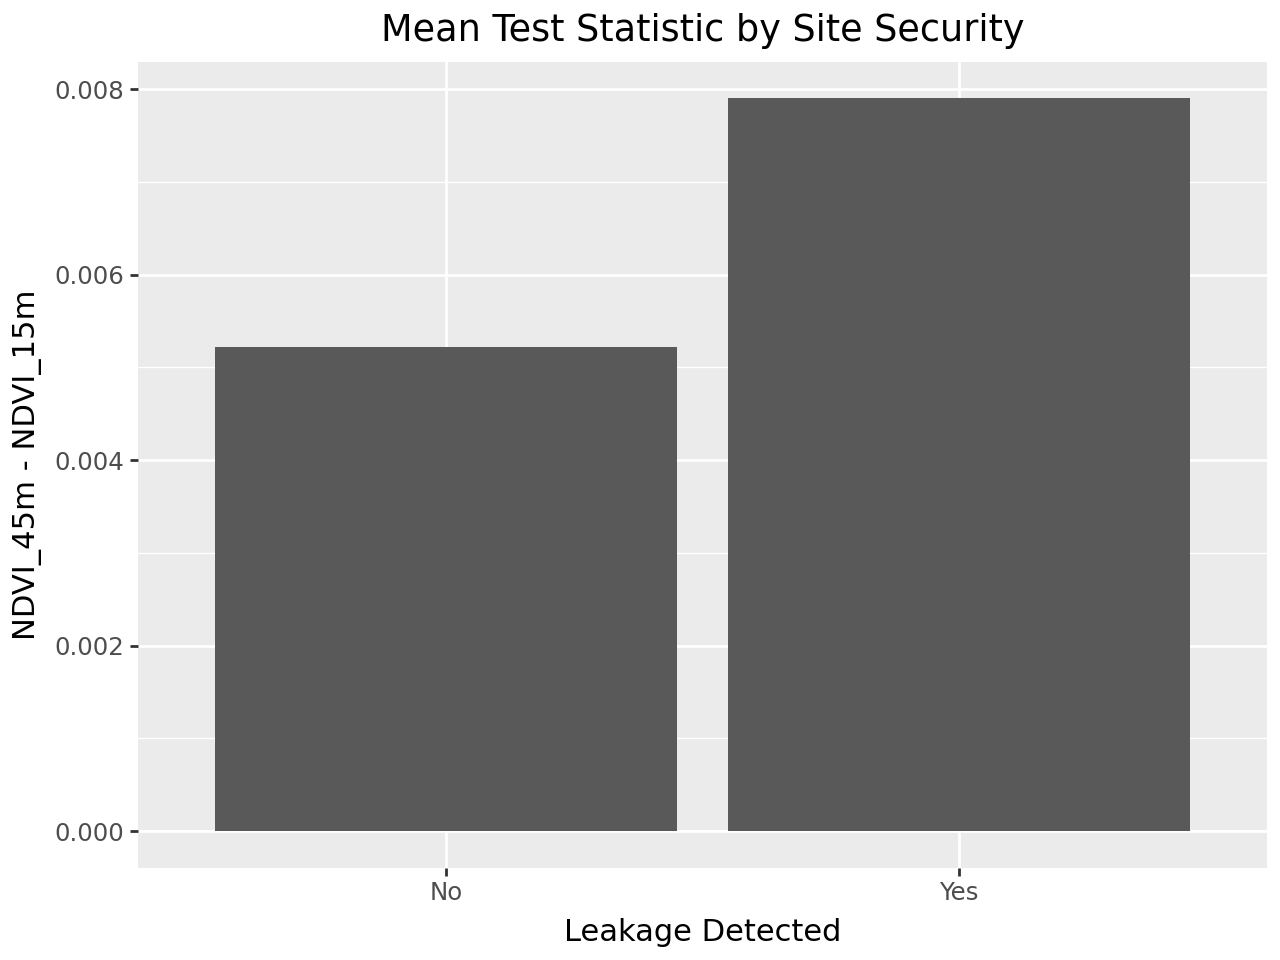

In [56]:
(ggplot(grouped[grouped['Leakage'] != 'Inconclusive'], aes(x='Leakage', y='test_stat')) 
 + geom_bar(stat='identity')  # use the values directly
 + labs(title='Mean Test Statistic by Site Security',
        x='Leakage Detected',
        y='NDVI_45m - NDVI_15m'))


In [59]:
p = (ggplot(grouped[grouped['Leakage'] != 'Inconclusive'], aes(x='Leakage', y='test_stat'))
     + geom_bar(stat='identity')  # use the values directly
     + labs(title='Mean Test Statistic by Site Security',
            x='Leakage Detected',
            y='NDVI_45m - NDVI_15m'))

# Save to PNG
p.save("Figure3.png", width=6, height=4, dpi=300)

In [51]:
np.var(miocic_gdf[miocic_gdf['Leakage'] == 'Yes']['NDVI_15m'])

0.03928090939184196

In [52]:
np.var(miocic_gdf[miocic_gdf['Leakage'] == 'No']['NDVI_15m'])

0.0849487269093251

In [53]:
# Split into two groups
ndvi_leak = miocic_gdf[miocic_gdf['Leakage'] == 'Yes']['NDVI_15m']
ndvi_no_leak = miocic_gdf[miocic_gdf['Leakage'] == 'No']['NDVI_15m']

# Run t-test
tstat, pval = ttest_ind(ndvi_leak, ndvi_no_leak, nan_policy='omit')

print("t-statistic:", tstat)
print("p-value:", pval)

t-statistic: -0.897458230589421
p-value: 0.3738629980425243


In [54]:
# Split into two groups
ndvi_leak = miocic_gdf[miocic_gdf['Leakage'] == 'Yes']['test_stat']
ndvi_no_leak = miocic_gdf[miocic_gdf['Leakage'] == 'No']['test_stat']

# Run t-test
tstat, pval = ttest_ind(ndvi_leak, ndvi_no_leak, alternative = 'less', equal_var= False, nan_policy='omit')

print("t-statistic:", tstat)
print("p-value:", pval)

t-statistic: 0.19608386101540545
p-value: 0.5745751775748164


In [55]:
from scipy.stats import mannwhitneyu

# Split into two groups
ndvi_leak = miocic_gdf[miocic_gdf['Leakage'] == 'Yes']['test_stat'].dropna()
ndvi_no_leak = miocic_gdf[miocic_gdf['Leakage'] == 'No']['test_stat'].dropna()

# Run Mann–Whitney U test
u_stat, pval = mannwhitneyu(ndvi_leak, ndvi_no_leak, alternative='less')

print("U-statistic:", u_stat)
print("p-value:", pval)

U-statistic: 159.0
p-value: 0.7582586596155576


# Visualize CGS Locations

In [14]:
site_color = {
    "No": "#1f77b4",         # blue
    "Yes": "#d62728",                 # red
    "Inconclusive": "#9467bd",  # purple 
}
site_paint = {
    "circle-color": ["get", "basin_security_color"],
    "circle-radius": 6,      
    "circle-opacity": 0.7,
    "circle-stroke-color": "#000000",
    "circle-stroke-width": 0.5}

In [15]:
miocic_gdf["basin_security_color"] = miocic_gdf[
    "Leakage"].map(site_color).fillna("#999999")

In [16]:
miocic_gdf["basin_security_color"]

0     #1f77b4
1     #d62728
2     #1f77b4
3     #1f77b4
4     #d62728
       ...   
56    #1f77b4
57    #1f77b4
58    #1f77b4
59    #1f77b4
60    #1f77b4
Name: basin_security_color, Length: 61, dtype: object

In [17]:
m = leafmap.Map(style = "positron")
m.add_gdf(miocic_gdf, 
          layer_type = 'circle',
          paint = site_paint,
         name = 'Leakage Detected?')
m

Html(children=[Map(calls=[['addControl', ('NavigationControl', {'showCompass': True, 'showZoom': True, 'visual…

6-9 DO NOT DO WHOLE YEAR

15m buffer vs 45m (3x)